# Checking the Velocity Distribution
## particles coordinates obtained from imageJ

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import trackpy as tp
import pandas as pd
import os
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.stats as sts
import scipy.constants as constants

In [2]:
folderPath = r'g:\My Drive\workAppState\prj_shocks\expData\data20230530velDistribTest_ImageJ_Connor'

In [3]:
inputsPath = folderPath + r'\inputs'
infilename = r'\360v_1mA_9sccm_91mtorr'

In [4]:
colnames=['x','y','frame']
indf = pd.read_csv(inputsPath + infilename  + r'.csv', usecols=[3,4,8],names=colnames, skiprows=1)


In [5]:
indf.head()

,x,y,frame
0,345.78586,13.41291,1
1,306.32614,14.01396,1
2,332.94084,13.89708,1
3,319.62251,14.91738,1
4,371.09624,14.78872,1


In [6]:
tracked_csv_dir = folderPath + r'\outputs' + r'\tracked' 
tracked_csv_filepath = tracked_csv_dir + infilename + r'_tracked.csv'
if not os.path.exists(tracked_csv_dir):
    os.makedirs(tracked_csv_dir)
    t_large = tp.link(indf,3,memory=1)
    # the better version is t_large = tp.link(indf,10,memory=0)
    t_large.to_csv(tracked_csv_filepath)    
else:
    t_large = pd.read_csv(tracked_csv_filepath)
t_large


,Unnamed: 0,x,y,frame,particle
0,0,345.78586,13.41291,1,0
1,1299,563.45040,319.49206,1,1
2,1298,513.90593,319.84384,1,2
3,1297,284.83552,319.66066,1,3
4,1296,206.13283,319.97588,1,4
...,...,...,...,...,...
1872186,1870898,210.52854,191.02396,968,1920
1872187,1870897,612.83741,188.58557,968,1541
1872188,1870896,494.81270,189.19780,968,1895
1872189,1870864,114.40066,184.15846,968,1864


In [7]:
#function get_velocities(df, step) calculates velocites of particles
# with a given step step.
def get_velocities(df, step):
#initialize empy arrays to store data:
    arr_particle = np.array([])
    arr_x = np.array([])
    arr_y = np.array([])
    arr_vx = np.array([])
    arr_vy = np.array([])
    arr_frame = np.array([])
    # get an array containing all frame numbers in the input dataframe:
    frames_listing = np.unique(np.array(df['frame']))
    #cycle throught all those frames:
    for iFrame in range(step, len(frames_listing)):
        #get current frame:
        cur_frame = frames_listing[iFrame]
        #select a dataframe containing data ONLY for that frame:
        df_front_frame = df[(df['frame'] == cur_frame)]
        print(iFrame)
        #cycle throught all particles in the frame and find their velocities as
        # position of the particle in that frame minus position of the same particles
        # step frames ago:
        for i in range(0, len(df_front_frame)):
            #take i-th particle in a frame
            cur_p = df_front_frame['particle'].iloc[i]
            cur_x = df_front_frame['x'].iloc[i]
            cur_y = df_front_frame['y'].iloc[i]
            #find a row with the same particle in a frame step frames ago:
            prev_frame_cur_row = df[((df['frame'] == cur_frame - step) & (df['particle'] == cur_p))]
            #if that particle excisted back then, we will get exactly ONE row:
            if (len(prev_frame_cur_row) == 1):
                #if this row exists, we can take position of that particle in that, previous, frame:
                prev_x = prev_frame_cur_row['x'].iloc[0]
                prev_y = prev_frame_cur_row['y'].iloc[0]
                # so we can calculate velocities:
                cur_vx = cur_x - prev_x
                cur_vy = cur_y - prev_y
                cur_particle = df_front_frame['particle'].iloc[i]
                #and append all parameters of that particle to our data arrays
                arr_vx = np.append(arr_vx, cur_vx)
                arr_vy = np.append(arr_vy, cur_vy)
                arr_particle = np.append(arr_particle, cur_particle)
                arr_x = np.append(arr_x, cur_x)
                arr_y = np.append(arr_y, cur_y)
                arr_frame = np.append(arr_frame, cur_frame)
    #save output as a dataframe containing all the info we need:
    data = {'frame':arr_frame, 'particle':arr_particle, 'x': arr_x, 'y': arr_y, 'vx': arr_vx, 'vy':arr_vy}
    ret_df = pd.DataFrame(data)
                
    return ret_df

In [8]:
# function get_velocities_fast(df, step) does the same thing as
# get_velocities(df, step), but very fast (by avoiding cycles and append())

In [9]:
def get_velocities_fast(df, step):
    df_sorted = df.sort_values(by = ['particle', 'frame'])
    grouped = df_sorted.groupby('particle')
    df_sorted['vx'] = grouped['x'].diff(periods = step)
    df_sorted['vy'] = grouped['y'].diff(periods = step)
    df_sorted = df_sorted.dropna()
    df_sorted = df_sorted.sort_values(by = ['frame', 'particle'])    
    return df_sorted

## Getting the Temperature Profiles

#### constants:

In [10]:
step = 1 # number of frames between the frames for calculating velocities
dust_mass = 4.0 / 3.0 * np.pi * (7.14E-6 / 2.0)**3 * 1510.0 #mass of the dust particles
N_points = 15 # number of points in the temperature profile
rate_for_vel = 99.0 / step # frequency for calculating particle speeds
mm_per_px = 1.0/40.3 # camera resolution
N_bins = 100
left_bins_border = -3.0
right_bins_border = 3.0

#### first, get velocities. May take some time:
#### Velocities obtained with step = 1:

In [11]:
vel_csv_dir = folderPath + r'\outputs\csvData\velocities_step01'
vel_csv_csv_filepath = vel_csv_dir + infilename + r'_velocities_step01.csv'
if not os.path.exists(vel_csv_dir):
    os.makedirs(vel_csv_dir)
    df_vel_step01 = get_velocities(t_large, step)
    df_vel_step01.to_csv(vel_csv_csv_filepath)    
else:
    df_vel_step01 = pd.read_csv(vel_csv_csv_filepath)
df_vel_step01.head()

,Unnamed: 0,frame,particle,x,y,vx,vy
0,0,2.0,9.0,250.48543,318.43861,0.01522,0.17691
1,1,2.0,12.0,173.12657,318.39599,-0.02031,0.06335
2,2,2.0,11.0,390.37302,317.69753,-0.28955,0.32418
3,3,2.0,27.0,500.84187,316.95665,0.07655,0.05680
4,4,2.0,7.0,437.83949,318.62216,-0.12883,0.07270


## Comparting FWHM Method, Direct Method and Fitting method

#### subtracting global cloud drift:

In [12]:
meanVx = np.mean(df_vel_step01['vx'])
meanVy = np.mean(df_vel_step01['vy'])
arr_vx_noDrift = np.array(df_vel_step01['vx']) - meanVx
arr_vy_noDrift = np.array(df_vel_step01['vy']) - meanVy

##### calculating histogram

In [13]:
my_bins = np.linspace(left_bins_border, right_bins_border, N_bins)
total_vx_samples = len(arr_vx_noDrift)
counts_x, bins_x = np.histogram(arr_vx_noDrift, bins = my_bins)
arr_bins_x_centers = 0.5 * (bins_x[1:] + bins_x[:-1]) # array of the bin centers
bin_wid = np.abs(arr_bins_x_centers[1] - arr_bins_x_centers[0])
arr_vx_freqs = counts_x / total_vx_samples / bin_wid # histogram frequencies

(-1.0, 1.0)

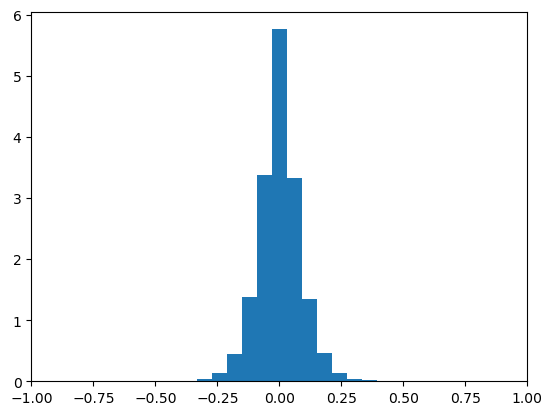

In [14]:
#plotting the histogram
fig_hist_x, ax_hist_x = plt.subplots()
ax_hist_x.bar(arr_bins_x_centers, arr_vx_freqs, width = bin_wid)
ax_hist_x.set_xlim([-1, 1])

#### Since the datapoints are sparse, do a cubic splines interpolation:

In [15]:
# ten times more dense bins:
arr_bins_dense = np.linspace(np.min(arr_bins_x_centers), np.max(arr_bins_x_centers), num = N_bins * 10)
#interpolating function made of cubic splines:
fx = interp1d(arr_bins_x_centers, arr_vx_freqs, kind = 'cubic')
#interpolate the data:
arr_f_x_interp = fx(arr_bins_dense)
#plot
#ax_hist_x.plot(arr_bins_dense, arr_f_x_interp, color = 'red', label = 'cubic spline interpolation')
#fig_hist_x

#### FWHM method:

In [16]:
f_vx_halfmax = np.max(arr_f_x_interp) / 2.0 #calculate the halfmaximum of the interpolated data
#find all x-values corresponding to y-valies laying ABOVE the halfmaximum
arr_vx_above_halfmax = arr_bins_dense[(arr_f_x_interp > f_vx_halfmax)]
#minimum of the x-values will be the left boundary
left_bound_vx = np.min(arr_vx_above_halfmax)
# maximum is the right boundary
right_bound_vx = np.max(arr_vx_above_halfmax)
#FWHM is rgith boundary minus left boundary
FWHM_vx = right_bound_vx - left_bound_vx
FWHM_vx

0.13674280340946998

In [17]:
sigma_vx_fromFWHM = FWHM_vx / 2.0 / np.sqrt(2 * np.log(2))
sigma_vx_fromFWHM

0.05806932198408086

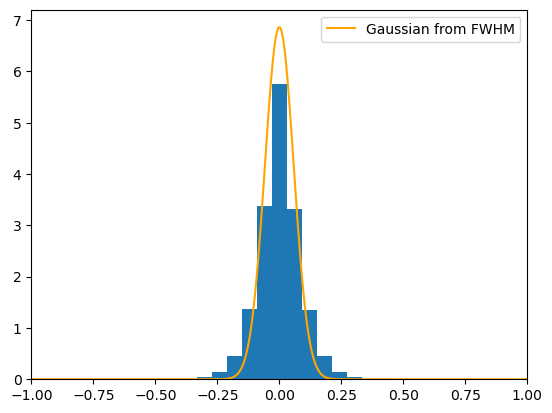

In [18]:
ax_hist_x.plot(arr_bins_dense, 1 / np.sqrt(2 * np.pi) / sigma_vx_fromFWHM * np.exp(-(0 - arr_bins_dense)**2 / 2 / sigma_vx_fromFWHM**2), color = 'orange',
        label = r'Gaussian from FWHM')
legend = ax_hist_x.legend()
fig_hist_x

#### Direct Method:

In [19]:
sigma_vx = np.std(arr_vx_noDrift)
sigma_vx
mu_vx = np.mean(arr_vx_noDrift)
mu_vx

-9.166305561330021e-19

In [20]:
ax_hist_x.plot(arr_bins_dense, 1 / np.sqrt(2 * np.pi) / sigma_vx * np.exp(-(mu_vx - arr_bins_dense)**2 / 2 / sigma_vx**2), color = 'black',
        label = r'direct method Gaussian')
legend = ax_hist_x.legend()

#### Fitting the histogram with Gaussian

In [21]:
def my_gauss(x, mu, sigma):
    return 1 / np.sqrt(2 * np.pi) / sigma * np.exp(-(mu - x)**2 / 2 / sigma**2)

params, params_cov = curve_fit(my_gauss, arr_bins_x_centers, arr_vx_freqs,  bounds=(0, [0.000001, 10.]))

In [22]:
params

array([4.94065646e-324, 7.32687539e-002])

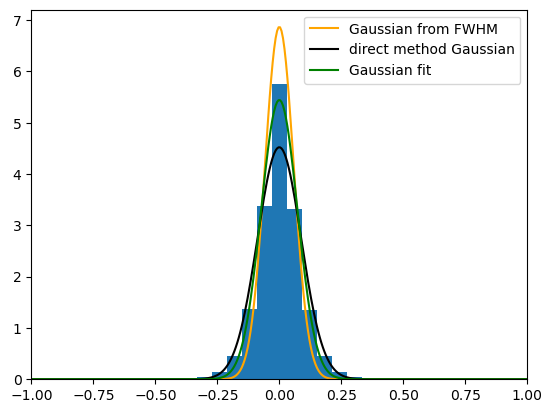

In [23]:
ax_hist_x.plot(arr_bins_dense, 1 / np.sqrt(2 * np.pi) / params[1] * np.exp(-(params[0] - arr_bins_dense)**2 / 2 / params[1]**2), color = 'green',
        label = r'Gaussian fit')
legend = ax_hist_x.legend()
fig_hist_x

## Getting the Temperature Profiles. 

### Direct Standard Deviation Method

In [24]:
def get_temper_profile_direct(df_vel, coord_axis, vel_component, N_points):
    left_x = np.min(df_vel[coord_axis])
    right_x = np.max(df_vel[coord_axis])
    x_grid = np.linspace(left_x, right_x, num = N_points)
    delta_x = x_grid[1] - x_grid[0]
    x_grid = x_grid + delta_x/2
    x_grid = x_grid[:-1]
    arr_temper_frosigmas = np.array([])
    arr_errors = np.array([])
    for el_x in x_grid:
        sub_df = df_vel[(df_vel[coord_axis] > el_x - delta_x / 2) & (df_vel[coord_axis] < el_x + delta_x / 2)]
        sub_df.head()
        cur_sigma = np.std(np.array(sub_df[vel_component]))
        sigma_SI = cur_sigma * mm_per_px / 1000.0 * rate_for_vel
        err_sigma_SI = sigma_SI / np.sqrt( 2.0 * (len(sub_df[vel_component]) - 1.0))
        temper_eV = dust_mass * sigma_SI**2 / constants.elementary_charge
        err_eV = 2 * sigma_SI * err_sigma_SI * dust_mass / constants.elementary_charge
        arr_temper_frosigmas = np.append(arr_temper_frosigmas, temper_eV)
        arr_errors = np.append(arr_errors, err_eV)
    return x_grid, arr_temper_frosigmas, arr_errors

In [25]:
x_grid, arr_temper_x_dir, arr_err_temper_x = get_temper_profile_direct(df_vel_step01, 'x', 'vx',  N_points)
x_grid, arr_temper_y_dir, arr_err_temper_y = get_temper_profile_direct(df_vel_step01, 'x', 'vy',  N_points)
df_temper = pd.DataFrame({'x_px':x_grid, 'T_x_eV':arr_temper_x_dir, 'err_T_x_eV':arr_err_temper_x, 'T_y_eV':arr_temper_y_dir, 'err_T_y':arr_err_temper_y})
df_temper.head()
temper_csv_path = folderPath + r'\outputs\csvData\temperatures_step01'
temper_csv_filepath = temper_csv_path + infilename + r'_temper_direct_step01.csv'
if not os.path.exists(temper_csv_path):
    os.makedirs(temper_csv_path)
    
df_temper.to_csv(temper_csv_filepath)

df_temper.head()

,x_px,T_x_eV,err_T_x_eV,T_y_eV,err_T_y
0,37.077385,0.081557,0.000407,0.081381,0.000406
1,85.931735,0.073411,0.000288,0.070126,0.000275
2,134.786085,0.070843,0.000254,0.072290,0.000260
3,183.640435,0.072268,0.000252,0.071652,0.000250
4,232.494785,0.071770,0.000248,0.072761,0.000251


Text(0, 0.5, '$T$ (eV)')

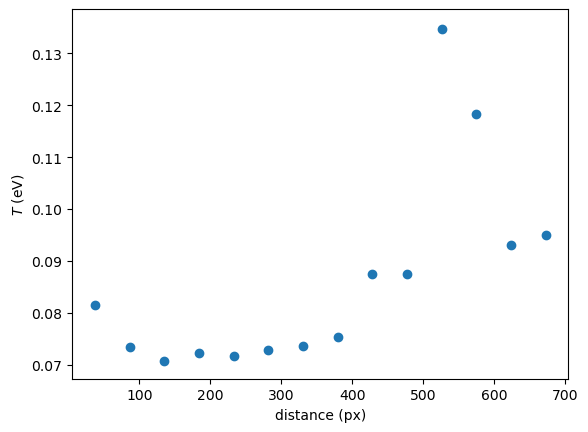

In [26]:
fig, ax = plt.subplots()
ax.errorbar(x_grid, arr_temper_x_dir, yerr = arr_err_temper_x, fmt = 'o', label = '$T_x$, direct method')
#ax.errorbar(x_grid, arr_temper_y_dir, yerr = arr_err_temper_y, fmt = 'o', label = '$T_y$, direct method')
#ax.set_xlim(0, 400)
#ax.set_ylim(0,0.05)
ax.set_xlabel('distance (px)')
ax.set_ylabel('$T$ (eV)')
#ax.legend()

### Fitting Method


In [50]:
def get_temper_profile_fit(df_vel, coord_axis, vel_component, N_points):
    left_x = np.min(df_vel_step01[coord_axis])
    right_x = np.max(df_vel_step01[coord_axis])
    x_grid = np.linspace(left_x, right_x, num = N_points)
    delta_x = x_grid[1] - x_grid[0]
    x_grid = x_grid + delta_x/2
    x_grid = x_grid[:-1]
    arr_temper_frosigmas = np.array([])
    arr_errors = np.array([])
    arr_hist_bins_and_counts = arr_bins_x_centers
    arr_sigmas = np.array([])
    for el_x in x_grid:
        sub_df = df_vel[(df_vel[coord_axis] > el_x - delta_x / 2) & (df_vel[coord_axis] < el_x + delta_x / 2)]
        total_samples = len(sub_df)
        mean_v = np.mean(sub_df[vel_component])
        arr_1dvel_noDrift = np.array(sub_df[vel_component]) - mean_v
        counts, bins = np.histogram(arr_1dvel_noDrift, bins = my_bins)
        arr_bins_centers = 0.5 * (bins[1:] + bins[:-1])
        bin_wid = np.abs(arr_bins_x_centers[1] - arr_bins_x_centers[0])
        arr_freqs = counts / total_samples / bin_wid
        ini_guess = [0.0, np.std(np.array(sub_df[vel_component]))]
        params, params_cov = curve_fit(my_gauss, arr_bins_centers, arr_freqs, p0 = ini_guess, bounds=(0, [0.000001, ini_guess[1] * 1.5 ]))
        sigma_SI = params[1] * mm_per_px / 1000.0 * rate_for_vel
        temper_eV = dust_mass * sigma_SI**2 / constants.elementary_charge
        err_sigma_SI = np.sqrt(params_cov[1,1]) * mm_per_px / 1000.0 * rate_for_vel
        err_eV = 2 * sigma_SI * err_sigma_SI * dust_mass / constants.elementary_charge
        arr_temper_frosigmas = np.append(arr_temper_frosigmas, temper_eV)
        arr_errors = np.append(arr_errors, err_eV)
        arr_sigmas = np.append(arr_sigmas, params[1])
        arr_hist_bins_and_counts = np.vstack((arr_hist_bins_and_counts, arr_freqs))
            
    return x_grid, arr_temper_frosigmas, arr_errors, arr_sigmas, arr_hist_bins_and_counts

In [51]:
x_grid, arr_temper_x_fit, arr_err_temper_x, arr_sigmas_x, arr_histo_bins_fit_vx = get_temper_profile_fit(df_vel_step01, 'x', 'vx',  N_points)
x_grid, arr_temper_y_fit, arr_err_temper_y, arr_sigmas_y, arr_histo_bins_fit_vy = get_temper_profile_fit(df_vel_step01, 'x', 'vy',  N_points)
df_temper = pd.DataFrame({'x_px':x_grid, 'T_x_eV':arr_temper_x_fit, 'err_T_x_eV':arr_err_temper_x, 'T_y_eV':arr_temper_y_fit, 'err_T_y':arr_err_temper_y})
temper_csv_path = folderPath + r'\outputs\csvData\temperatures_step01'
temper_csv_filepath = temper_csv_path + infilename + r'_temper_fit_step01.csv'
if not os.path.exists(temper_csv_path):
    os.makedirs(temper_csv_path)
    
df_temper.to_csv(temper_csv_filepath)

df_temper.head()

,x_px,T_x_eV,err_T_x_eV,T_y_eV,err_T_y
0,37.077385,0.050310,0.001246,0.056179,0.001109
1,85.931735,0.053487,0.001230,0.056407,0.000967
2,134.786085,0.056936,0.001082,0.058977,0.001038
3,183.640435,0.056630,0.001171,0.058683,0.000981
4,232.494785,0.055961,0.001210,0.057169,0.001160


In [52]:
histograms_csv_path = folderPath + r'\outputs\csvData\histograms_step01'
histograms_csv_filepath = histograms_csv_path + infilename + r'_histograms_step01.csv'
if not os.path.exists(histograms_csv_path):
    os.makedirs(histograms_csv_path)
titles = ['v_x'] + ['freq for x_bin = {:.1f}'.format(elem) for elem in x_grid]
header = ', '.join(titles)
np.savetxt(histograms_csv_filepath, arr_histo_bins_fit_vx, delimiter=',', header=header)


In [53]:
header

'v_x, freq for x_bin = 37.1, freq for x_bin = 85.9, freq for x_bin = 134.8, freq for x_bin = 183.6, freq for x_bin = 232.5, freq for x_bin = 281.3, freq for x_bin = 330.2, freq for x_bin = 379.1, freq for x_bin = 427.9, freq for x_bin = 476.8, freq for x_bin = 525.6, freq for x_bin = 574.5, freq for x_bin = 623.3, freq for x_bin = 672.2'

In [54]:
#fig, ax = plt.subplots()
ax.errorbar(x_grid, arr_temper_x_fit, yerr = arr_err_temper_x, fmt = 'o', label = '$T_x$, fit method')
#ax.errorbar(x_grid, arr_temper_frosigmas, yerr = arr_err_temper_y, fmt = 'o', label = '$T_y$, fit method')
#ax.set_xlim(0, 400)
#ax.set_ylim(0,0.05)
ax.set_xlabel('distance (px)')
ax.set_ylabel('$T$ (eV)')
ax.legend()

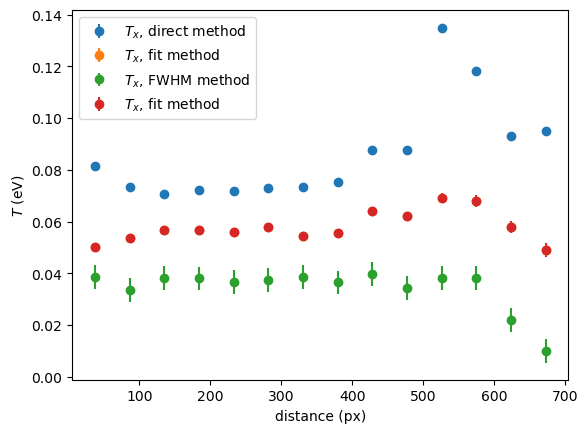

In [55]:
fig

### FWHM Method


In [32]:
def get_FWHM(arr_1dvel, N_bins):
    FWHM = False
    mean_v =  np.mean(arr_1dvel)
    arr_1dvel_noDrift = arr_1dvel - mean_v
    counts, bins = np.histogram(arr_1dvel_noDrift, bins = N_bins)
    arr_bins_centers = 0.5 * (bins[1:] + bins[:-1])
    arr_freqs = counts / len(arr_1dvel_noDrift)
    arr_bins_dense = np.linspace(np.min(arr_bins_centers), np.max(arr_bins_centers), num = N_bins * 100)
    f = interp1d(arr_bins_centers, arr_freqs, kind = 'cubic')
    arr_f_interp = f(arr_bins_dense)
    f_halfmax = np.max(arr_f_interp) / 2.0
    arr_bins_above_halfmax = arr_bins_dense[(arr_f_interp > f_halfmax)]
    left_bound = np.min(arr_bins_above_halfmax)
    right_bound = np.max(arr_bins_above_halfmax)
    FWHM = right_bound - left_bound
    err_FWHM = np.abs(arr_bins_centers[1] - arr_bins_centers[0])
    return FWHM, err_FWHM

In [33]:
def get_temper_eV(FWHM, rate_betw_pos, mm_per_pix, part_mass):
    sigma = FWHM / 2.0 / np.sqrt(2.0 * np.log(2.0))
    
    sigma_SI = sigma * mm_per_px / 1000.0 * rate_for_vel
    
    temper_eV = part_mass * sigma_SI**2 / constants.elementary_charge 
    
    return temper_eV

In [34]:
def get_temper_profile_FWHM(df_vel, coord_axis, vel_component, N_points):
    left_x = np.min(df_vel[coord_axis])
    right_x = np.max(df_vel[coord_axis])
    x_grid = np.linspace(left_x, right_x, num = N_points)
    delta_x = x_grid[1] - x_grid[0]
    x_grid = x_grid + delta_x/2
    x_grid = x_grid[:-1]
    arr_temper = np.array([])
    arr_err = np.array([])
    for el_x in x_grid:
        sub_df = df_vel[(df_vel[coord_axis] > el_x - delta_x / 2) & (df_vel[coord_axis] < el_x + delta_x / 2)]
        cur_fwhm, err_fwhm = get_FWHM(np.array(sub_df[vel_component]), N_bins)
        cur_temper = get_temper_eV(cur_fwhm, rate_for_vel, mm_per_px, dust_mass)
        sigma = cur_fwhm / 2.0 / np.sqrt(2.0 * np.log(2.0))
        sigma_SI = sigma * mm_per_px / 1000.0 * rate_for_vel
        err = err_fwhm / 2.0 / np.sqrt(2.0 * np.log(2.0))
        err_SI = err * mm_per_px / 1000.0 * rate_for_vel
        temper_eV = dust_mass * sigma_SI**2 / constants.elementary_charge 
        err_eV = 2 * sigma_SI * err_SI * dust_mass / constants.elementary_charge
        arr_temper = np.append(arr_temper, temper_eV)
        arr_err = np.append(arr_err, err_eV)
    return x_grid, arr_temper, err_eV

In [35]:
x_grid, arr_temper_x_FWHM, arr_err_temper_x = get_temper_profile_FWHM(df_vel_step01, 'x', 'vx',  N_points)
x_grid, arr_temper_y_FWHM, arr_err_temper_y = get_temper_profile_FWHM(df_vel_step01, 'x', 'vy',  N_points)
df_temper = pd.DataFrame({'x_px':x_grid, 'T_x_eV':arr_temper_x_FWHM, 'err_T_x_eV':arr_err_temper_x, 'T_y_eV':arr_temper_y_FWHM, 'err_T_y':arr_err_temper_y})
temper_csv_path = folderPath + r'\outputs\csvData\temperatures_step01'
temper_csv_filepath = temper_csv_path + infilename + r'_temper_FWHM_step01.csv'
if not os.path.exists(temper_csv_path):
    os.makedirs(temper_csv_path)
    
df_temper.to_csv(temper_csv_filepath)

df_temper.head()

,x_px,T_x_eV,err_T_x_eV,T_y_eV,err_T_y
0,37.077385,0.038659,0.004613,0.041927,0.002485
1,85.931735,0.033690,0.004613,0.043654,0.002485
2,134.786085,0.038197,0.004613,0.046898,0.002485
3,183.640435,0.038031,0.004613,0.042955,0.002485
4,232.494785,0.036661,0.004613,0.039564,0.002485


In [36]:
#fig, ax = plt.subplots()
ax.errorbar(x_grid, arr_temper_x_FWHM, yerr = arr_err_temper_x, fmt = 'o', label = '$T_x$, FWHM method')
#ax.errorbar(x_grid, arr_temper_frosigmas, yerr = arr_err_temper_y, fmt = 'o', label = '$T_y$, fit method')
#ax.set_xlim(0, 400)
#ax.set_ylim(0,0.05)
ax.set_xlabel('distance (px)')
ax.set_ylabel('$T$ (eV)')
ax.legend()

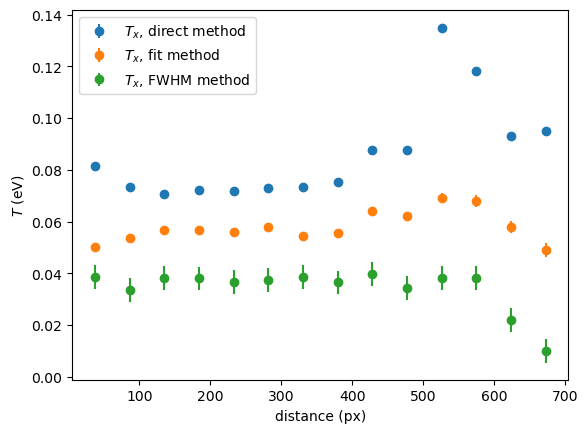

In [37]:
fig